In [73]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
#define constants
g = 9.80665 #acceleration due to gravity
m = 1    #mass of the bar
l = 0.5      #length of the bar
pi = 3.1415926535
Gamma = 0.9 #Discount factor

TauRange = 2*m*g*l  #max torque is twice of what is required to balances the mass in 90 degree configuration 

res = 3  #resolution of the control input or the totan number of discretized values of the control inpput. This value should ne odd number

ThetaRes = 101 #resolution of theta : creating the discrete state from the originally continuous state theta
                #Odd number in the resolution will ensure that the theta for the vertically up position is included in the discrete state

OmegaRes = 101

OmegaRange = 14

OmegaDisc = np.linspace(-OmegaRange, OmegaRange, OmegaRes)
Ts = 0.05 #50 ms sample time

k = 0.1 #damping constant

ThetaTarget = pi #Angle at which we intend to stabilize

ThetaDisc = np.linspace(0, 2*pi, ThetaRes)
TauDisc = np.linspace(-TauRange, TauRange, res)

def thetaDDot(Theta, Tau):
    return 1.5*g/l*np.sin(Theta) - Tau*3/m/l**2

def reward(Theta, ThetaTarget):
    #1/(Theta - ThetaTarget + 0.001)
    # thetadiff = abs(Theta - ThetaTarget)
    # return 1/(thetadiff**10 + 0.00001)
    return 1- np.cos(Theta)

def DynSS(y, t, m,l,k,Tau,g):
    Theta, Omega = y
    dydt = [Omega, -1.5*g/l*np.sin(Theta) + 3*Tau/m/l**2 - 3*k*Omega/m/l**2]
    return dydt

def nextState(y,Tau, Ts):
    y0 = y
    sol = odeint(DynSS, y0, [0, Ts], args=(m,l,k,Tau,g))
    return sol[1,:]

def closestDiscInd(DiscArr, val):
    diff = np.absolute(DiscArr -val)
    Ind = np.argmin(diff)
    return Ind


In [66]:
Q_new = np.zeros((ThetaRes, OmegaRes, res))
def Q_learning(QInit, ThetaTarget, Ts):
    Q = np.copy(QInit)
    episodes = 150000
    maxEpisodeLength = 800
    eps = 0.1
    for i in range(episodes):
        Theta = 0
        Omega = 0
        
        ThetaHist = [Theta]
        CritThetaCount = 0
        ThetaVisitCount = np.zeros(ThetaRes)
        
        for j in range(maxEpisodeLength):
            #First find the next state
            TauInd = np.random.randint(res) #generating a random action
            Tau = TauDisc[TauInd]
            #print('Theta: ', Theta, 'Omega: ', Omega, 'Tau: ', Tau)
            Theta_n, Omega_n = nextState([Theta, Omega], Tau, Ts)
            if Theta_n >= 2*pi:
                Theta_n = Theta_n - 2*pi
            elif Theta_n < 0:
                Theta_n = Theta_n + 2*pi
            ThetaHist.append(Theta_n)
            #print('Theta_n: ', Theta_n)
            if Omega_n > OmegaRange:
                #print('Omega exceeding the bounds, stopping learning')
                break

            #Update the Q function
            #First find the closest Theta value in the discretized theta to the current Theta and Theta_n
            
            ThetaInd = closestDiscInd(ThetaDisc, Theta)
            Theta_nInd = closestDiscInd(ThetaDisc, Theta_n)
            OmegaInd = closestDiscInd(OmegaDisc, Omega)
            Omega_nInd = closestDiscInd(OmegaDisc, Omega_n)
            Q_new = np.copy(Q)
            f_term = Q[ThetaInd, OmegaInd, TauInd]
            s_term = reward(ThetaDisc[ThetaInd],  ThetaTarget) + Gamma*Q[Theta_nInd, Omega_nInd, :].max()
            #print(f_term)
            #print(s_term)
            Q_new[ThetaInd, OmegaInd, TauInd] = (1-eps)*f_term + eps*s_term
            
            # print(f_term, s_term)
            # print('ThetaInd, TauInd', ThetaInd, TauInd)
            # print('s_term1: ', reward(ThetaDisc[ThetaInd], Tau, ThetaTarget), 's_term2: ', Gamma*Q[Theta_nInd, :].max())
            # print('Q[Theta_nInd, :]',Q[Theta_nInd, :])
            # print('theta', ThetaDisc[ThetaInd])
            #print('Tau: ', Tau, 'Theta_n: ', Theta_n, 'Omwga_n : ', Omega_n  )

            
            Theta, Omega = ThetaDisc[Theta_nInd], OmegaDisc[Omega_nInd]
            Q = np.copy(Q_new)
        if i%1000 == 0:
            print(i/1000, "Q-update", f_term- s_term, 'f_term: ', f_term, 's_term: ', s_term)
            
    #print(CritThetaCount/Iterations*100, "Explored critical region")
    return Q_new, ThetaHist

Q, ThetaHist = Q_learning(Q_new, ThetaTarget, Ts)


0.0 Q-update -1.6845471060111639 f_term:  0.0 s_term:  1.6845471060111639
1.0 Q-update -1.1253332336943687 f_term:  0.0 s_term:  1.1253332336943687
2.0 Q-update -1.539399394315549 f_term:  0.33949908773419724 s_term:  1.8788984820497463
3.0 Q-update -1.8116244949172944 f_term:  0.7825887163757739 s_term:  2.5942132112930683
4.0 Q-update -0.03882959837943249 f_term:  0.032533117038971965 s_term:  0.07136271541840446
5.0 Q-update -0.08424835320481985 f_term:  0.04326369020051221 s_term:  0.12751204340533207
6.0 Q-update -0.1751849995434266 f_term:  0.02894285027168428 s_term:  0.20412784981511087
7.0 Q-update -0.4576372331117744 f_term:  2.014670848184595 s_term:  2.4723080812963696
8.0 Q-update -0.34890221372602703 f_term:  0.20737756039817526 s_term:  0.5562797741242023
9.0 Q-update -0.16850093920365575 f_term:  0.23944077531742544 s_term:  0.4079417145210812
10.0 Q-update -0.2376872182466676 f_term:  2.486966867261014 s_term:  2.7246540855076815
11.0 Q-update -0.3429145446020945 f_ter

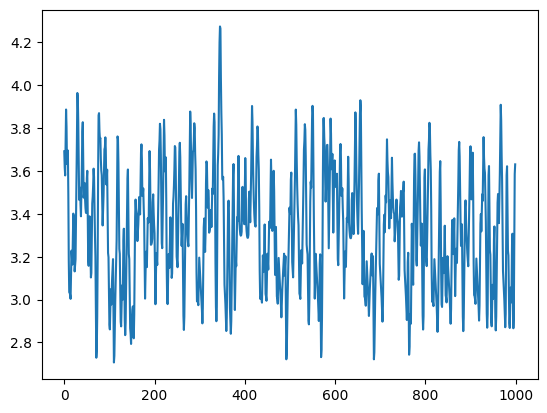

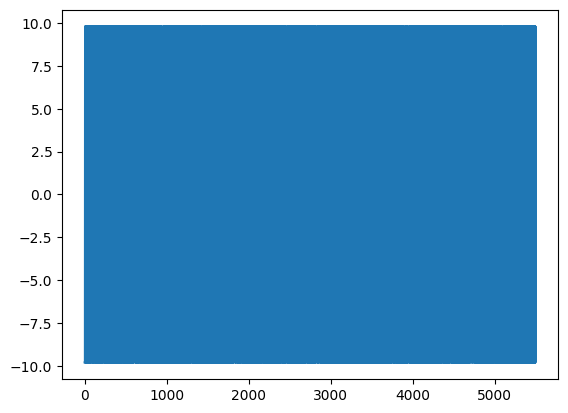

In [72]:
# Controling pendulum using the learned Q-function
Theta0 = 0
Omega0 = 0

# Want to stabilize the Theta at pi (Vertically inverted)

simIter = 5500
Theta, Omega = Theta0, Omega0
ThetaSim = [Theta]
TauSim = []
for i in range(simIter):
        
    ThetaInd = closestDiscInd(ThetaDisc, Theta)
    OmegaInd = closestDiscInd(OmegaDisc, Omega)
    #Finding optimal action for the current state

    optTauInd = np.argmax(Q[ThetaInd, OmegaInd,:])
    optTau = TauDisc[optTauInd]
    TauSim.append(optTau)
    Theta_n, Omega_n = nextState([Theta, Omega], optTau, Ts)
    if Theta_n >= 2*pi:
        Theta_n = Theta_n - 2*pi
    elif Theta_n < 0:
        Theta_n = Theta_n + 2*pi
    ThetaSim.append(Theta_n)
    Theta, Omega = Theta_n, Omega_n

plt.figure(1)
plt.plot(ThetaSim[1000:2000])
plt.figure(2)
plt.plot(TauSim)



In [13]:
for i in range(90,120):
    print(ThetaSim[i], TauSim[i])

1.2448063085811967 2.549729000000001
1.3543551258948436 5.295591
1.5024493623541233 9.022118
1.7798888381995077 2.157463
2.1338789250192547 1.7651970000000006
2.464518132644369 7.6491869999999995
2.869987644286082 0.19613300000000145
3.3467056113237055 -2.157462999999999
3.780972656841607 -2.745861999999999
4.1603561600749 -3.5303939999999994
4.486213946825904 -5.883989999999999
4.724684115459678 -9.022117999999999
4.803007540923939 -6.472389
4.7227223718762295 -9.022117999999999
4.492405618235737 -5.883989999999999
4.127856106417147 6.080123
3.8482457660253733 3.726527000000001
3.7744542627422275 -9.414384
3.662241750991835 -8.825985
3.325220606744715 -1.1767979999999998
2.875384341116585 -8.041452999999999
2.2972650445738676 6.864655000000001
1.6860044488838664 7.453054
1.249671830469616 2.549729000000001
0.9165549969421642 -2.5497289999999992
0.5461962452775626 3.3342610000000015
0.1732040096414664 -1.1767979999999998
6.123579945805841 -5.099457999999999
5.72990743315376 -8.825985
5

In [17]:
closestDiscInd(ThetaDisc, 2.133878925019254)
Q[170, :]

array([25230.61545622, 27011.69918418, 29178.71026792, 26132.72233843,
       28156.58584582, 25625.38035889, 28013.53919594, 27824.07518993,
       25572.48028229, 25474.43449625, 26993.96780077, 25096.5836829 ,
       27871.3566984 , 25150.54434511, 29389.66997786, 25694.24600464,
       29713.38161292, 24282.5558864 , 25961.50722456, 27415.9261189 ,
       30511.77029116, 25092.40379803, 29328.23092911, 29309.40766934,
       26094.1697278 , 25685.55663448, 25893.41677687, 28559.39570062,
       26261.29004308, 27707.98340025, 27880.04680831, 26946.72324127,
       27649.40966877, 29234.58176875, 28569.71958615, 26416.38528227,
       25134.66525881, 28759.32834712, 29998.71736407, 30822.54575385,
       25836.41679621, 28046.5355498 , 27230.85433047, 26901.58155867,
       28659.55751078, 27328.5509733 , 28692.37716031, 30515.21574433,
       27869.99238968, 31986.79831576, 28607.8817975 , 30649.68277058,
       31192.25484261, 29599.72740092, 31650.49344065, 30553.77156728,
      